### Testing access to the NHL API

In [211]:
import pandas as pd
from nhlpy.api.query.builder import QueryBuilder, QueryContext
from nhlpy.nhl_client import NHLClient
from nhlpy.api.query.filters.franchise import FranchiseQuery
from nhlpy.api.query.filters.shoot_catch import ShootCatchesQuery
from nhlpy.api.query.filters.draft import DraftQuery
from nhlpy.api.query.filters.season import SeasonQuery
from nhlpy.api.query.filters.game_type import GameTypeQuery
from nhlpy.api.query.filters.position import PositionQuery, PositionTypes
from nhlpy.api.query.filters.status import StatusQuery
from nhlpy.api.query.filters.opponent import OpponentQuery
from nhlpy.api.query.filters.home_road import HomeRoadQuery
from nhlpy.api.query.filters.experience import ExperienceQuery
from nhlpy.api.query.filters.decision import DecisionQuery

In [212]:
client = NHLClient(verbose=True)

In [213]:
print(client)

## Team info prep

Using teams_info method with date parameter fetches inforamtion about the team for the given date.

In [214]:
team_info = client.teams.teams_info(date="2024-10-31")

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/standings/2024-10-31 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/standings/2024-10-31
INFO:httpx:HTTP Request: GET https://api.nhle.com/stats/rest/en/franchise "HTTP/1.1 200 OK"
INFO:root:API URL: https://api.nhle.com/stats/rest/en/franchise


In [215]:
df_team_info = pd.DataFrame(team_info)

In [216]:
df_team_info.head()

,conference,division,name,common_name,abbr,logo,franchise_id
0,"{'abbr': 'W', 'name': 'Western'}","{'abbr': 'C', 'name': 'Central'}",Winnipeg Jets,Jets,WPG,https://assets.nhle.com/logos/nhl/svg/WPG_ligh...,35
1,"{'abbr': 'E', 'name': 'Eastern'}","{'abbr': 'M', 'name': 'Metropolitan'}",New Jersey Devils,Devils,NJD,https://assets.nhle.com/logos/nhl/svg/NJD_ligh...,23
2,"{'abbr': 'W', 'name': 'Western'}","{'abbr': 'P', 'name': 'Pacific'}",Vegas Golden Knights,Golden Knights,VGK,https://assets.nhle.com/logos/nhl/svg/VGK_ligh...,38
3,"{'abbr': 'E', 'name': 'Eastern'}","{'abbr': 'A', 'name': 'Atlantic'}",Florida Panthers,Panthers,FLA,https://assets.nhle.com/logos/nhl/svg/FLA_ligh...,33
4,"{'abbr': 'E', 'name': 'Eastern'}","{'abbr': 'M', 'name': 'Metropolitan'}",Washington Capitals,Capitals,WSH,https://assets.nhle.com/logos/nhl/svg/WSH_seco...,24


Data in some fields is stored as a dictionary with abbreviated and full names, namely for Conference and Division.

We can access a full name value under a given key with the get method:

In [217]:
df_team_info["conference"].apply(lambda x: x.get("name") if isinstance(x, dict) else x).unique()

array(['Western', 'Eastern'], dtype=object)

Now wrapping it under a function that accepts a column name and a dictionary key as arguments.

In [218]:
def get_default_value(column, get_value):
    return column.apply(lambda x: x.get(get_value) if isinstance(x, dict) else x)

Create a loop to go through columns we want to change.

In [219]:
columns_to_change = ["conference", "division"]

for column in columns_to_change:
    df_team_info[column] = get_default_value(df_team_info[column], "name")

In [220]:
df_team_info.head()

,conference,division,name,common_name,abbr,logo,franchise_id
0,Western,Central,Winnipeg Jets,Jets,WPG,https://assets.nhle.com/logos/nhl/svg/WPG_ligh...,35
1,Eastern,Metropolitan,New Jersey Devils,Devils,NJD,https://assets.nhle.com/logos/nhl/svg/NJD_ligh...,23
2,Western,Pacific,Vegas Golden Knights,Golden Knights,VGK,https://assets.nhle.com/logos/nhl/svg/VGK_ligh...,38
3,Eastern,Atlantic,Florida Panthers,Panthers,FLA,https://assets.nhle.com/logos/nhl/svg/FLA_ligh...,33
4,Eastern,Metropolitan,Washington Capitals,Capitals,WSH,https://assets.nhle.com/logos/nhl/svg/WSH_seco...,24


Saving teams abbreviations as a series for further iterations. 

In [221]:
s_teams = df_team_info["abbr"]

In [222]:
s_teams.info()

<class 'pandas.core.series.Series'>
RangeIndex: 32 entries, 0 to 31
Series name: abbr
Non-Null Count  Dtype 
--------------  ----- 
32 non-null     object
dtypes: object(1)
memory usage: 388.0+ bytes


## Roster Data analysis

In roster table, we want to get players attributes for further filtering

In [223]:
# Select a season and a team to perform a query
season_id = 20242025
team_abbr = "COL"

In [224]:
roster_data = client.teams.roster(team_abbr=team_abbr, season=season_id)

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/COL/20242025 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/roster/COL/20242025


Let's inspect the object we received from the query.

In [225]:
roster_data

{'forwards': [{'id': 8479525,
   'headshot': 'https://assets.nhle.com/mugs/nhl/20242025/COL/8479525.png',
   'firstName': {'default': 'Ross'},
   'lastName': {'default': 'Colton'},
   'sweaterNumber': 20,
   'positionCode': 'C',
   'shootsCatches': 'L',
   'heightInInches': 72,
   'weightInPounds': 194,
   'heightInCentimeters': 183,
   'weightInKilograms': 88,
   'birthDate': '1996-09-11',
   'birthCity': {'default': 'Robbinsville'},
   'birthCountry': 'USA',
   'birthStateProvince': {'default': 'NJ'}},
  {'id': 8477494,
   'headshot': 'https://assets.nhle.com/mugs/nhl/20242025/COL/8477494.png',
   'firstName': {'default': 'Jonathan'},
   'lastName': {'default': 'Drouin'},
   'sweaterNumber': 27,
   'positionCode': 'L',
   'shootsCatches': 'L',
   'heightInInches': 71,
   'weightInPounds': 198,
   'heightInCentimeters': 180,
   'weightInKilograms': 90,
   'birthDate': '1995-03-28',
   'birthCity': {'default': 'Ste-Agathe'},
   'birthCountry': 'CAN',
   'birthStateProvince': {'default'

The returned dictionary contains positions as keys and list of dictionaries with individual players' info as values. Let's inspect the goalies record. 

In [226]:
roster_data["goalies"]

[{'id': 8478406,
  'headshot': 'https://assets.nhle.com/mugs/nhl/20242025/COL/8478406.png',
  'firstName': {'default': 'Mackenzie'},
  'lastName': {'default': 'Blackwood'},
  'sweaterNumber': 39,
  'positionCode': 'G',
  'shootsCatches': 'L',
  'heightInInches': 76,
  'weightInPounds': 225,
  'heightInCentimeters': 193,
  'weightInKilograms': 102,
  'birthDate': '1996-12-09',
  'birthCity': {'default': 'Thunder Bay'},
  'birthCountry': 'CAN',
  'birthStateProvince': {'default': 'ON'}},
 {'id': 8481529,
  'headshot': 'https://assets.nhle.com/mugs/nhl/20242025/COL/8481529.png',
  'firstName': {'default': 'Trent'},
  'lastName': {'default': 'Miner'},
  'sweaterNumber': 50,
  'positionCode': 'G',
  'shootsCatches': 'L',
  'heightInInches': 73,
  'weightInPounds': 185,
  'heightInCentimeters': 185,
  'weightInKilograms': 84,
  'birthDate': '2001-02-05',
  'birthCity': {'default': 'Brandon'},
  'birthCountry': 'CAN',
  'birthStateProvince': {'default': 'MB'}},
 {'id': 8475809,
  'headshot': 

We can combine all three values for defensemen, forwards and goales in a list and convert that into a dataframe for cleaning and analysis.

In [227]:
roster_data_combined = roster_data["forwards"] + roster_data["defensemen"] + roster_data ["goalies"]

In [228]:
df_team_roster = pd.DataFrame(roster_data_combined)

In [229]:
df_team_roster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   27 non-null     int64 
 1   headshot             27 non-null     object
 2   firstName            27 non-null     object
 3   lastName             27 non-null     object
 4   sweaterNumber        27 non-null     int64 
 5   positionCode         27 non-null     object
 6   shootsCatches        27 non-null     object
 7   heightInInches       27 non-null     int64 
 8   weightInPounds       27 non-null     int64 
 9   heightInCentimeters  27 non-null     int64 
 10  weightInKilograms    27 non-null     int64 
 11  birthDate            27 non-null     object
 12  birthCity            27 non-null     object
 13  birthCountry         27 non-null     object
 14  birthStateProvince   18 non-null     object
dtypes: int64(6), object(9)
memory usage: 3.3+ KB


In [230]:
df_team_roster.head()

,id,headshot,firstName,lastName,sweaterNumber,positionCode,shootsCatches,heightInInches,weightInPounds,heightInCentimeters,weightInKilograms,birthDate,birthCity,birthCountry,birthStateProvince
0,8479525,https://assets.nhle.com/mugs/nhl/20242025/COL/...,{'default': 'Ross'},{'default': 'Colton'},20,C,L,72,194,183,88,1996-09-11,{'default': 'Robbinsville'},USA,{'default': 'NJ'}
1,8477494,https://assets.nhle.com/mugs/nhl/20242025/COL/...,{'default': 'Jonathan'},{'default': 'Drouin'},27,L,L,71,198,180,90,1995-03-28,{'default': 'Ste-Agathe'},CAN,{'default': 'QC'}
2,8479746,https://assets.nhle.com/mugs/nhl/20242025/COL/...,{'default': 'Tye'},{'default': 'Felhaber'},48,L,L,71,185,180,84,1998-08-05,{'default': 'Pembroke'},CAN,{'default': 'ON'}
3,8484976,https://assets.nhle.com/mugs/nhl/20242025/COL/...,{'default': 'Jere'},{'default': 'Innala'},22,L,L,69,183,175,83,1998-03-17,{'default': 'Hauho'},FIN,NaN
4,8483930,https://assets.nhle.com/mugs/nhl/20242025/COL/...,{'default': 'Ivan'},{'default': 'Ivan'},82,C,L,72,190,183,86,2002-08-20,{'default': 'Ostrava'},CZE,NaN


Data in some of the fields is represented as dictionaries with information like First and Last Names and Birth City can be presented in multiple languages. Let's inspect them to understand how we can transform the data to make analysis easy.   

In [231]:
df_team_roster.loc[ : ,["firstName", "lastName", "birthCity", "birthStateProvince", "birthCountry"]]

,firstName,lastName,birthCity,birthStateProvince,birthCountry
0,{'default': 'Ross'},{'default': 'Colton'},{'default': 'Robbinsville'},{'default': 'NJ'},USA
1,{'default': 'Jonathan'},{'default': 'Drouin'},{'default': 'Ste-Agathe'},{'default': 'QC'},CAN
2,{'default': 'Tye'},{'default': 'Felhaber'},{'default': 'Pembroke'},{'default': 'ON'},CAN
3,{'default': 'Jere'},{'default': 'Innala'},{'default': 'Hauho'},NaN,FIN
4,{'default': 'Ivan'},{'default': 'Ivan'},{'default': 'Ostrava'},NaN,CZE
5,{'default': 'Parker'},{'default': 'Kelly'},{'default': 'Camrose'},{'default': 'AB'},CAN
6,{'default': 'Joel'},{'default': 'Kiviranta'},"{'default': 'Vantaa', 'sv': 'Vanda'}",NaN,FIN
7,{'default': 'Artturi'},{'default': 'Lehkonen'},"{'default': 'Piikkio', 'cs': 'Piikkiö', 'fi': ...",NaN,FIN
8,{'default': 'Nathan'},{'default': 'MacKinnon'},{'default': 'Halifax'},{'default': 'NS'},CAN
9,{'default': 'Casey'},{'default': 'Mittelstadt'},{'default': 'Eden Prairie'},{'default': 'MN'},USA


We can reuse the function we created earlier to extract values under "default" key, which is English spellings.

In [232]:
# Test the function on the Last Name column
get_default_value(df_team_roster["lastName"], "default").tail(10)

17    Kylington
18       Ludvig
19        Makar
20     Malinski
21       Manson
22    Middleton
23        Toews
24    Blackwood
25        Miner
26    Wedgewood
Name: lastName, dtype: object

Now in the dataframe, we apply the function to the fields we want to be cleaned.

In [233]:
columns_to_change = ["firstName", "lastName", "birthCity", "birthStateProvince"]

for column in columns_to_change:
    df_team_roster[column] = get_default_value(df_team_roster[column], "default")

In [234]:
df_team_roster.loc[df_team_roster["lastName"] == "Georgiev"].T

""
id
headshot
firstName
lastName
sweaterNumber
positionCode
shootsCatches
heightInInches
weightInPounds
heightInCentimeters


For the purpose of our project we don't need certain fields such as "birthCity", "birthStateProvince", "weightInPounds" etc.

In [235]:
df_team_roster.drop(
    columns=["heightInInches", "weightInPounds", "birthCity", "birthStateProvince"],
    axis=1,
    inplace=True
)

In [236]:
df_team_roster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   27 non-null     int64 
 1   headshot             27 non-null     object
 2   firstName            27 non-null     object
 3   lastName             27 non-null     object
 4   sweaterNumber        27 non-null     int64 
 5   positionCode         27 non-null     object
 6   shootsCatches        27 non-null     object
 7   heightInCentimeters  27 non-null     int64 
 8   weightInKilograms    27 non-null     int64 
 9   birthDate            27 non-null     object
 10  birthCountry         27 non-null     object
dtypes: int64(4), object(7)
memory usage: 2.4+ KB


To be able to repeatedly clean data for all franchises, we create a function that will be reused in a loop.

In [237]:
def get_team_roster(team_abbr, season_id):
    
    # Load data
    data = client.teams.roster(team_abbr=team_abbr, season=season_id)
    data_combined = data["forwards"] + data["defensemen"] + data ["goalies"]
    df = pd.DataFrame(data_combined)

    if df.shape[1] > 0:
        # Clean columns
        columns_to_change = ["firstName", "lastName", "birthCity", "birthStateProvince"]
        for column in columns_to_change:
            df[column] = get_default_value(df[column], "default")

        # Drop columns
        df.drop(
            columns=["heightInInches", "weightInPounds", "birthCity", "birthStateProvince"],
            axis=1,
            inplace=True
        )

    return df

In [238]:
get_team_roster("DAL", "20242025").head()

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/DAL/20242025 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/roster/DAL/20242025


,id,headshot,firstName,lastName,sweaterNumber,positionCode,shootsCatches,heightInCentimeters,weightInKilograms,birthDate,birthCountry
0,8473994,https://assets.nhle.com/mugs/nhl/20242025/DAL/...,Jamie,Benn,14,L,L,191,93,1989-07-18,CAN
1,8476278,https://assets.nhle.com/mugs/nhl/20242025/DAL/...,Colin,Blackwell,15,C,R,173,86,1993-03-28,USA
2,8482145,https://assets.nhle.com/mugs/nhl/20242025/DAL/...,Mavrik,Bourque,22,C,R,180,82,2002-01-08,CAN
3,8480840,https://assets.nhle.com/mugs/nhl/20242025/DAL/...,Oskar,Bäck,10,C,L,193,92,2000-03-12,SWE
4,8474149,https://assets.nhle.com/mugs/nhl/20242025/DAL/...,Evgenii,Dadonov,63,R,L,180,85,1989-03-12,RUS


Checking what value is assigned to the season_id variable which we will use in the get_team_roster functions

In [239]:
season_id

20242025

In [240]:
list_of_roster_dfs = [] # Creating a list to store team rosters dataframes

for index, team in s_teams.items():
    df = get_team_roster(team, season_id)
    list_of_roster_dfs.append(df)

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/WPG/20242025 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/roster/WPG/20242025
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/NJD/20242025 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/roster/NJD/20242025
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/VGK/20242025 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/roster/VGK/20242025
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/FLA/20242025 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/roster/FLA/20242025
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/WSH/20242025 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/roster/WSH/20242025
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/DAL/20242025 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/roster/DAL/20242025
INFO:httpx:HTTP Request: GET

In [241]:
list_of_roster_dfs

[         id                                           headshot  firstName  \
 0   8478891  https://assets.nhle.com/mugs/nhl/20242025/WPG/...      Mason   
 1   8480289  https://assets.nhle.com/mugs/nhl/20242025/WPG/...     Morgan   
 2   8478398  https://assets.nhle.com/mugs/nhl/20242025/WPG/...       Kyle   
 3   8477940  https://assets.nhle.com/mugs/nhl/20242025/WPG/...    Nikolaj   
 4   8481019  https://assets.nhle.com/mugs/nhl/20242025/WPG/...      David   
 5   8480113  https://assets.nhle.com/mugs/nhl/20242025/WPG/...       Alex   
 6   8480845  https://assets.nhle.com/mugs/nhl/20242025/WPG/...     Rasmus   
 7   8476392  https://assets.nhle.com/mugs/nhl/20242025/WPG/...       Adam   
 8   8476480  https://assets.nhle.com/mugs/nhl/20242025/WPG/...  Vladislav   
 9   8475799  https://assets.nhle.com/mugs/nhl/20242025/WPG/...       Nino   
 10  8482149  https://assets.nhle.com/mugs/nhl/20242025/WPG/...       Cole   
 11  8476460  https://assets.nhle.com/mugs/nhl/20242025/WPG/... 

Using concat method we combine the dataframes in the list into a single dataframe.

In [242]:
df_team_roster_combined = pd.concat(list_of_roster_dfs)

In [243]:
df_team_roster_combined.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 787 entries, 0 to 23
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   787 non-null    int64 
 1   headshot             787 non-null    object
 2   firstName            787 non-null    object
 3   lastName             787 non-null    object
 4   sweaterNumber        787 non-null    int64 
 5   positionCode         787 non-null    object
 6   shootsCatches        787 non-null    object
 7   heightInCentimeters  787 non-null    int64 
 8   weightInKilograms    787 non-null    int64 
 9   birthDate            787 non-null    object
 10  birthCountry         787 non-null    object
dtypes: int64(4), object(7)
memory usage: 73.8+ KB


To test the combined dataframe, let's run a few queries.
Who is the tallest skater in the league? 

In [244]:
df_team_roster_combined.loc[df_team_roster_combined["heightInCentimeters"] == df_team_roster_combined["heightInCentimeters"].max()]

,id,headshot,firstName,lastName,sweaterNumber,positionCode,shootsCatches,heightInCentimeters,weightInKilograms,birthDate,birthCountry
10,8482460,https://assets.nhle.com/mugs/nhl/20242025/NYR/...,Matt,Rempe,73,C,R,206,116,2002-06-29,CAN


Who is the oldest Canadian goalie?

In [245]:
df_team_roster_combined.loc[
    (df_team_roster_combined['birthDate'] == df_team_roster_combined['birthDate'].min()) &
    (df_team_roster_combined['birthCountry'].str.upper() == 'CAN') &
    (df_team_roster_combined['positionCode'].str.upper() == 'G')
    ]

,id,headshot,firstName,lastName,sweaterNumber,positionCode,shootsCatches,heightInCentimeters,weightInKilograms,birthDate,birthCountry
25,8470594,https://assets.nhle.com/mugs/nhl/20242025/MIN/...,Marc-Andre,Fleury,29,G,L,188,84,1984-11-28,CAN


In [246]:
df_team_roster_combined.loc[df_team_roster_combined["id"] == 8479639].T

,14
id,8479639
headshot,https://assets.nhle.com/mugs/nhl/20242025/WPG/...
firstName,Dylan
lastName,Coghlan
sweaterNumber,52
positionCode,D
shootsCatches,R
heightInCentimeters,188
weightInKilograms,94
birthDate,1998-02-19


As goalies stats track different event compared to skaters, we pull stats for them separately.

In [247]:
df_team_roster_combined['positionCode'].unique()

array(['C', 'L', 'R', 'D', 'G'], dtype=object)

Saving skaters into a series.

In [248]:
s_skater_ids = df_team_roster_combined.loc[df_team_roster_combined['positionCode'] != "G"]['id']

In [249]:
s_skater_ids.info()

s_skater_ids.head()

<class 'pandas.core.series.Series'>
Index: 713 entries, 0 to 21
Series name: id
Non-Null Count  Dtype
--------------  -----
713 non-null    int64
dtypes: int64(1)
memory usage: 11.1 KB


0    8478891
1    8480289
2    8478398
3    8477940
4    8481019
Name: id, dtype: int64

Saving goalies ids into a series.

In [250]:
s_goalie_ids = df_team_roster_combined.loc[df_team_roster_combined['positionCode'] == "G"]['id']

In [251]:
s_goalie_ids.info()

s_goalie_ids.head()

<class 'pandas.core.series.Series'>
Index: 74 entries, 23 to 23
Series name: id
Non-Null Count  Dtype
--------------  -----
74 non-null     int64
dtypes: int64(1)
memory usage: 1.2 KB


23    8477480
24    8476945
20    8474596
21    8474593
22    8478499
Name: id, dtype: int64

## Game logs data prep

Game logs method requires player id, season id and game type arguments.
We can reuse the season id we declared earlier, while declaring the player id (Nathan MacKinnon) and game type (Regular Season) below.

In [252]:
player_id = 8477492
game_type = 2

In [253]:
game_logs_data = client.stats.player_game_log(player_id=player_id, season_id=season_id, game_type=game_type)

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8477492/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8477492/game-log/20242025/2


In [254]:
df_game_logs = pd.DataFrame(game_logs_data)

In [255]:
df_game_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   gameId              41 non-null     int64 
 1   teamAbbrev          41 non-null     object
 2   homeRoadFlag        41 non-null     object
 3   gameDate            41 non-null     object
 4   goals               41 non-null     int64 
 5   assists             41 non-null     int64 
 6   commonName          41 non-null     object
 7   opponentCommonName  41 non-null     object
 8   points              41 non-null     int64 
 9   plusMinus           41 non-null     int64 
 10  powerPlayGoals      41 non-null     int64 
 11  powerPlayPoints     41 non-null     int64 
 12  gameWinningGoals    41 non-null     int64 
 13  otGoals             41 non-null     int64 
 14  shots               41 non-null     int64 
 15  shifts              41 non-null     int64 
 16  shorthandedGoals    41 non-n

Inspecting the most recent record and transposing for better readability.

In [256]:
df_game_logs.head(1).T

,0
gameId,2024020639
teamAbbrev,COL
homeRoadFlag,H
gameDate,2025-01-06
goals,0
assists,1
commonName,{'default': 'Avalanche'}
opponentCommonName,{'default': 'Panthers'}
points,1
plusMinus,1


There are a few columns we can drop as they are not required / could be found in the team info table.

In [257]:
df_game_logs.drop(columns=["commonName", "opponentCommonName"], inplace=True)

For TOI (Time on Ice) field, we convert the values to seconds to allow easier aggregations.

In [258]:
# Check if the TOI is in MM:SS format
if len(df_game_logs["toi"][0].split(":")) == 2:
    # If so, convert to seconds by multiplying minutes by 60 and adding the seconds value.
    print(int(df_game_logs["toi"][0].split(":")[0]) * 60 + int(df_game_logs["toi"][0].split(":")[1]))
else:
    # if not, calculate hours first (mostly for goalies)
    print(int(df_game_logs["toi"][0].split(":")[0]) * 60 * 60 + int(df_game_logs["toi"][0].split(":")[1]) * 60 + int(df_game_logs["toi"][0].split(":")[2]))

1405


Translate the above if-else into a lambda function that can be applied to all rows

In [259]:
df_game_logs["toi"].apply(
    lambda x: 
        int(x.split(":")[0]) * 60 + int(x.split(":")[1])
        if len(x.split(":")) == 2
        else int(x.split(":")[0]) * 60 * 60 + int(x.split(":")[1]) * 60 + int(x.split(":")[2])
    )

0     1405
1     1524
2     1576
3     1392
4     1148
5     1256
6     1129
7     1398
8     1501
9     1286
10    1417
11    1056
12    1306
13    1367
14    1505
15    1413
16    1409
17    1562
18    1625
19    1311
20    1344
21    1336
22    1359
23    1326
24    1485
25    1469
26    1579
27    1469
28    1461
29    1352
30    1498
31    1497
32    1394
33    1257
34    1311
35    1200
36    1428
37    1428
38    1380
39    1403
40    1293
Name: toi, dtype: int64

In [260]:
df_game_logs["toi"] = df_game_logs["toi"].apply(
    lambda x: 
        int(x.split(":")[0]) * 60 + int(x.split(":")[1])
        if len(x.split(":")) == 2
        else int(x.split(":")[0]) * 60 * 60 + int(x.split(":")[1]) * 60 + int(x.split(":")[2])
    )

As we are going to loop through players in each franchise, we assign player id and season id for further analysis as they aren't included.

In [261]:
df_game_logs["playerId"] = player_id
df_game_logs["seasonId"] = season_id

In [262]:
df_game_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   gameId             41 non-null     int64 
 1   teamAbbrev         41 non-null     object
 2   homeRoadFlag       41 non-null     object
 3   gameDate           41 non-null     object
 4   goals              41 non-null     int64 
 5   assists            41 non-null     int64 
 6   points             41 non-null     int64 
 7   plusMinus          41 non-null     int64 
 8   powerPlayGoals     41 non-null     int64 
 9   powerPlayPoints    41 non-null     int64 
 10  gameWinningGoals   41 non-null     int64 
 11  otGoals            41 non-null     int64 
 12  shots              41 non-null     int64 
 13  shifts             41 non-null     int64 
 14  shorthandedGoals   41 non-null     int64 
 15  shorthandedPoints  41 non-null     int64 
 16  opponentAbbrev     41 non-null     object
 17 

Create a function to load and clean game logs data.

In [263]:
def get_game_logs(player_id, season_id, game_type):
    
    # Get the data
    data = client.stats.player_game_log(player_id=player_id, season_id=season_id, game_type=game_type)
    df = pd.DataFrame(data)
    if df.shape[1] > 0:
        # Drop columns
        df.drop(columns=["commonName", "opponentCommonName"], inplace=True)
        
        # Format time on ice
        df["toiInSeconds"] = df["toi"].apply(
            lambda x: 
                int(x.split(":")[0]) * 60 + int(x.split(":")[1]) 
                if len(x.split(":")) == 2 
                else int(x.split(":")[0]) * 60 * 60 + int(x.split(":")[1]) * 60 + int(x.split(":")[2]))
        df.drop(columns=["toi"], inplace=True)

        # Append player and season ids
        df["playerId"] = player_id
        df["seasonId"] = season_id

    return df

In [264]:
get_game_logs(player_id, season_id, game_type)

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8477492/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8477492/game-log/20242025/2


,gameId,teamAbbrev,homeRoadFlag,gameDate,goals,assists,points,plusMinus,powerPlayGoals,powerPlayPoints,...,otGoals,shots,shifts,shorthandedGoals,shorthandedPoints,opponentAbbrev,pim,toiInSeconds,playerId,seasonId
0,2024020639,COL,H,2025-01-06,0,1,1,1,0,0,...,0,3,23,0,0,FLA,0,1405,8477492,20242025
1,2024020626,COL,H,2025-01-04,0,1,1,0,0,1,...,0,2,25,0,0,MTL,0,1524,8477492,20242025
2,2024020610,COL,H,2025-01-02,0,3,3,2,0,1,...,0,3,27,0,0,BUF,0,1576,8477492,20242025
3,2024020597,COL,H,2024-12-31,0,1,1,2,0,0,...,0,6,24,0,0,WPG,0,1392,8477492,20242025
4,2024020564,COL,R,2024-12-27,0,3,3,3,0,0,...,0,4,23,0,0,UTA,5,1148,8477492,20242025
5,2024020543,COL,H,2024-12-22,0,2,2,0,0,1,...,0,2,22,0,0,SEA,0,1256,8477492,20242025
6,2024020527,COL,R,2024-12-20,1,2,3,2,0,1,...,0,3,21,0,0,ANA,0,1129,8477492,20242025
7,2024020520,COL,R,2024-12-19,0,2,2,-1,0,2,...,0,3,24,0,0,SJS,0,1398,8477492,20242025
8,2024020496,COL,R,2024-12-16,0,0,0,-1,0,0,...,0,4,24,0,0,VAN,0,1501,8477492,20242025
9,2024020484,COL,H,2024-12-14,2,1,3,3,0,0,...,0,3,24,0,0,NSH,0,1286,8477492,20242025


Goalies game logs stats are returned in a different format to skaters.

In [265]:
goalie_player_id = 8477480

In [266]:
game_logs_data = client.stats.player_game_log(player_id=goalie_player_id, season_id=season_id, game_type=game_type)

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8477480/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8477480/game-log/20242025/2


In [267]:
df_game_logs_goalies = pd.DataFrame(game_logs_data)

In [268]:
df_game_logs_goalies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gameId              9 non-null      int64  
 1   teamAbbrev          9 non-null      object 
 2   homeRoadFlag        9 non-null      object 
 3   gameDate            9 non-null      object 
 4   goals               9 non-null      int64  
 5   assists             9 non-null      int64  
 6   commonName          9 non-null      object 
 7   opponentCommonName  9 non-null      object 
 8   gamesStarted        9 non-null      int64  
 9   decision            9 non-null      object 
 10  shotsAgainst        9 non-null      int64  
 11  goalsAgainst        9 non-null      int64  
 12  savePctg            9 non-null      float64
 13  shutouts            9 non-null      int64  
 14  opponentAbbrev      9 non-null      object 
 15  pim                 9 non-null      int64  
 16  toi         

In [269]:
df_game_logs_goalies.drop(columns=["commonName", "opponentCommonName"], inplace=True)

In [270]:
df_game_logs_goalies["playerId"] = goalie_player_id
df_game_logs_goalies["seasonId"] = season_id

In [271]:
df_game_logs_goalies.head().T

,0,1,2,3,4
gameId,2024020597,2024020511,2024020439,2024020374,2024020329
teamAbbrev,WPG,WPG,WPG,WPG,WPG
homeRoadFlag,R,R,H,R,R
gameDate,2024-12-31,2024-12-18,2024-12-08,2024-11-29,2024-11-23
goals,0,0,0,0,0
assists,0,0,0,0,0
gamesStarted,1,1,1,1,1
decision,L,L,L,L,L
shotsAgainst,36,31,27,30,35
goalsAgainst,3,3,3,4,3


In [272]:
get_game_logs(goalie_player_id, season_id, game_type)

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8477480/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8477480/game-log/20242025/2


,gameId,teamAbbrev,homeRoadFlag,gameDate,goals,assists,gamesStarted,decision,shotsAgainst,goalsAgainst,savePctg,shutouts,opponentAbbrev,pim,toiInSeconds,playerId,seasonId
0,2024020597,WPG,R,2024-12-31,0,0,1,L,36,3,0.916667,0,COL,0,3489,8477480,20242025
1,2024020511,WPG,R,2024-12-18,0,0,1,L,31,3,0.903226,0,ANA,0,3573,8477480,20242025
2,2024020439,WPG,H,2024-12-08,0,0,1,L,27,3,0.888889,0,CBJ,0,3462,8477480,20242025
3,2024020374,WPG,R,2024-11-29,0,0,1,L,30,4,0.866667,0,VGK,0,3499,8477480,20242025
4,2024020329,WPG,R,2024-11-23,0,0,1,L,35,3,0.914286,0,NSH,0,3536,8477480,20242025
5,2024020259,WPG,R,2024-11-14,0,0,1,L,28,3,0.892857,0,TBL,0,3478,8477480,20242025
6,2024020171,WPG,R,2024-11-01,0,0,1,W,22,2,0.909091,0,CBJ,0,3600,8477480,20242025
7,2024020129,WPG,R,2024-10-26,0,0,1,W,29,3,0.896552,0,CGY,0,3600,8477480,20242025
8,2024020088,WPG,H,2024-10-20,0,0,1,W,42,3,0.928571,0,PIT,0,3593,8477480,20242025


In [273]:
season_id

20242025

In [274]:
game_type

2

Import time and httpx modules to improve the API call process and error handling.

In [275]:
import time
import httpx

For goalies ID, we call the game logs function and save the outcome to the list.

In [276]:
list_of_goalie_game_logs_dfs = []

for index, player in s_goalie_ids.items():
    try: 
        df = get_game_logs(player, season_id, game_type)
        list_of_goalie_game_logs_dfs.append(df)
        time.sleep(0.5)
    except httpx.RequestError as e:
        print(f"Request failed for player {player}: {e}")

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8477480/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8477480/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8476945/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8476945/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8474596/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8474596/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8474593/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8474593/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8478499/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8478499/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api

In [277]:
list_of_skaters_game_logs_dfs = []

for index, player in s_skater_ids.items():
    try:
        df = get_game_logs(player, season_id, game_type)
        list_of_skaters_game_logs_dfs.append(df)
        time.sleep(0.5)
    except httpx.RequestError as e:
        print(f"Request failed for player {player}: {e}")

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8478891/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8478891/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8480289/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8480289/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8478398/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8478398/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8477940/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8477940/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8481019/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8481019/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api

In [278]:
df_game_logs_goalies = pd.concat(list_of_goalie_game_logs_dfs)

In [279]:
df_game_logs_skaters = pd.concat(list_of_skaters_game_logs_dfs)

In [280]:
df_game_logs_skaters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22274 entries, 0 to 39
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   gameId             22274 non-null  int64 
 1   teamAbbrev         22274 non-null  object
 2   homeRoadFlag       22274 non-null  object
 3   gameDate           22274 non-null  object
 4   goals              22274 non-null  int64 
 5   assists            22274 non-null  int64 
 6   points             22274 non-null  int64 
 7   plusMinus          22274 non-null  int64 
 8   powerPlayGoals     22274 non-null  int64 
 9   powerPlayPoints    22274 non-null  int64 
 10  gameWinningGoals   22274 non-null  int64 
 11  otGoals            22274 non-null  int64 
 12  shots              22274 non-null  int64 
 13  shifts             22274 non-null  int64 
 14  shorthandedGoals   22274 non-null  int64 
 15  shorthandedPoints  22274 non-null  int64 
 16  opponentAbbrev     22274 non-null  object
 17  p

In [281]:
df_game_logs_skaters.describe()

,gameId,goals,assists,points,plusMinus,powerPlayGoals,powerPlayPoints,gameWinningGoals,otGoals,shots,shifts,shorthandedGoals,shorthandedPoints,pim,toiInSeconds,playerId,seasonId
count,2.227400e+04,22274.000000,22274.000000,22274.000000,22274.000000,22274.000000,22274.000000,22274.000000,22274.000000,22274.000000,22274.000000,22274.000000,22274.000000,22274.000000,22274.000000,2.227400e+04,22274.0
mean,2.024020e+09,0.172219,0.288902,0.461121,-0.005387,0.034031,0.098905,0.027117,0.004400,1.604157,20.904283,0.004085,0.007812,0.450166,999.644698,8.478819e+06,20242025.0
std,1.848403e+02,0.429221,0.564277,0.724677,1.199630,0.189070,0.334968,0.162427,0.066186,1.498781,4.763805,0.064489,0.090057,1.284571,269.340266,2.736451e+03,0.0
min,2.024020e+09,0.000000,0.000000,0.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,34.000000,8.470600e+06,20242025.0
25%,2.024020e+09,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,813.000000,8.476882e+06,20242025.0
50%,2.024020e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,21.000000,0.000000,0.000000,0.000000,995.000000,8.478519e+06,20242025.0
75%,2.024020e+09,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,24.000000,0.000000,0.000000,0.000000,1191.000000,8.480995e+06,20242025.0
max,2.024021e+09,4.000000,5.000000,6.000000,6.000000,3.000000,4.000000,1.000000,1.000000,13.000000,40.000000,2.000000,2.000000,21.000000,1986.000000,8.484976e+06,20242025.0


In [282]:
df_game_logs_goalies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1280 entries, 0 to 17
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gameId          1280 non-null   int64  
 1   teamAbbrev      1280 non-null   object 
 2   homeRoadFlag    1280 non-null   object 
 3   gameDate        1280 non-null   object 
 4   goals           1280 non-null   int64  
 5   assists         1280 non-null   int64  
 6   gamesStarted    1280 non-null   int64  
 7   decision        1227 non-null   object 
 8   shotsAgainst    1280 non-null   int64  
 9   goalsAgainst    1280 non-null   int64  
 10  savePctg        1280 non-null   float64
 11  shutouts        1280 non-null   int64  
 12  opponentAbbrev  1280 non-null   object 
 13  pim             1280 non-null   int64  
 14  toiInSeconds    1280 non-null   int64  
 15  playerId        1280 non-null   int64  
 16  seasonId        1280 non-null   int64  
dtypes: float64(1), int64(11), object(5)
memo

In [283]:
df_game_logs_goalies.describe()

,gameId,goals,assists,gamesStarted,shotsAgainst,goalsAgainst,savePctg,shutouts,pim,toiInSeconds,playerId,seasonId
count,1.280000e+03,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1.280000e+03,1280.0
mean,2.024020e+09,0.000781,0.015625,0.961719,27.023438,2.661719,0.895546,0.055469,0.031250,3444.366406,8.478351e+06,20242025.0
std,1.851377e+02,0.027951,0.130218,0.191949,7.460362,1.547407,0.072578,0.228982,0.248136,548.777293,2.354224e+03,0.0
min,2.024020e+09,0.000000,0.000000,0.000000,2.000000,0.000000,0.400000,0.000000,0.000000,83.000000,8.470594e+06,20242025.0
25%,2.024020e+09,0.000000,0.000000,1.000000,23.000000,2.000000,0.863636,0.000000,0.000000,3501.000000,8.476914e+06,20242025.0
50%,2.024020e+09,0.000000,0.000000,1.000000,27.000000,3.000000,0.906250,0.000000,0.000000,3598.000000,8.478470e+06,20242025.0
75%,2.024020e+09,0.000000,0.000000,1.000000,32.000000,4.000000,0.941596,0.000000,0.000000,3600.000000,8.480045e+06,20242025.0
max,2.024021e+09,1.000000,2.000000,1.000000,54.000000,8.000000,1.000000,1.000000,2.000000,3900.000000,8.483710e+06,20242025.0


## Joining tables into an analytics ready state

We want to join game logs data with player attributes from the team roster dataframe. The output will allow us to perform more advances querying with player attributes in the same view as performance. 

In [284]:
df_skaters_performance = df_game_logs_skaters.merge(df_team_roster_combined, how="left", left_on="playerId", right_on="id")

df_goalies_performance = df_game_logs_goalies.merge(df_team_roster_combined, how="left", left_on="playerId", right_on="id")

In [285]:
df_skaters_performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22274 entries, 0 to 22273
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   gameId               22274 non-null  int64 
 1   teamAbbrev           22274 non-null  object
 2   homeRoadFlag         22274 non-null  object
 3   gameDate             22274 non-null  object
 4   goals                22274 non-null  int64 
 5   assists              22274 non-null  int64 
 6   points               22274 non-null  int64 
 7   plusMinus            22274 non-null  int64 
 8   powerPlayGoals       22274 non-null  int64 
 9   powerPlayPoints      22274 non-null  int64 
 10  gameWinningGoals     22274 non-null  int64 
 11  otGoals              22274 non-null  int64 
 12  shots                22274 non-null  int64 
 13  shifts               22274 non-null  int64 
 14  shorthandedGoals     22274 non-null  int64 
 15  shorthandedPoints    22274 non-null  int64 
 16  oppo

In [286]:
df_skaters_performance.head(1).T

,0
gameId,2024020574
teamAbbrev,WPG
homeRoadFlag,H
gameDate,2024-12-28
goals,0
assists,0
points,0
plusMinus,0
powerPlayGoals,0
powerPlayPoints,0


In [287]:
df_goalies_performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gameId               1280 non-null   int64  
 1   teamAbbrev           1280 non-null   object 
 2   homeRoadFlag         1280 non-null   object 
 3   gameDate             1280 non-null   object 
 4   goals                1280 non-null   int64  
 5   assists              1280 non-null   int64  
 6   gamesStarted         1280 non-null   int64  
 7   decision             1227 non-null   object 
 8   shotsAgainst         1280 non-null   int64  
 9   goalsAgainst         1280 non-null   int64  
 10  savePctg             1280 non-null   float64
 11  shutouts             1280 non-null   int64  
 12  opponentAbbrev       1280 non-null   object 
 13  pim                  1280 non-null   int64  
 14  toiInSeconds         1280 non-null   int64  
 15  playerId             1280 non-null   i

In [288]:
df_goalies_performance.head(1).T

,0
gameId,2024020597
teamAbbrev,WPG
homeRoadFlag,R
gameDate,2024-12-31
goals,0
assists,0
gamesStarted,1
decision,L
shotsAgainst,36
goalsAgainst,3


## Database preparation

With data preparation complete, we look into creating SQLite database to store the data.

In [289]:
import sqlite3

In [290]:
con = sqlite3.connect("hnl.db")

In [291]:
cur = con.cursor()

In [292]:
# declare table names
teams_info_table = "teams_info"
players_roster_table = "players_info"
skaters_game_logs_table = "skaters_game_logs"
goalies_game_logs_table = "goalies_game_logs"

In [293]:
# cur.execute(f"DROP TABLE IF EXISTS skaters_game_logs")

In [294]:
cur.execute(f"""
  CREATE TABLE IF NOT EXISTS {teams_info_table} (
    id INTEGER PRIMARY KEY,
    abbr VARCHAR(16),
    name VARCHAR(32),
    logo VARCHAR(64),
    conference VARCHAR(16),
    division VARCHAR(16)
  )
""")

In [295]:
cur.execute(f"""
  CREATE TABLE IF NOT EXISTS {players_roster_table} (
    id INTEGER PRIMARY KEY,
    headshot VARCHAR(64),
    firstName VARCHAR(64),
    lastName VARCHAR(64),
    sweaterNumber INTEGER,
    positionCode VARCHAR(8),
    shootsCatches VARCHAR(8),
    heightInCentimeters INTEGER,
    weightInKilograms INTEGER,
    birthDate VARCHAR(64),
    birthCountry VARCHAR(8)
  )      
""")

In [296]:
cur.execute(f"""CREATE TABLE IF NOT EXISTS {skaters_game_logs_table} (
    gameId INTEGER,
    teamAbbrev VARCHAR(8),
    homeRoadFlag VARCHAR(8),
    gameDate STRING,
    goals INTEGER,        
    assists INTEGER,         
    points INTEGER,       
    plusMinus INTEGER,         
    powerPlayGoals INTEGER,         
    powerPlayPoints INTEGER,         
    gameWinningGoals INTEGER,         
    otGoals INTEGER,
    shots INTEGER,      
    shifts INTEGER,         
    shorthandedGoals INTEGER,         
    shorthandedPoints INTEGER,         
    opponentAbbrev VARCHAR(8),     
    pim INTEGER,
    toiInSeconds INTEGER,        
    playerId INTEGER,         
    seasonId INTEGER,
    PRIMARY KEY (gameId, playerId, seasonId)
    FOREIGN KEY (teamAbbrev) REFERENCES {teams_info_table}(abbr)
    FOREIGN KEY (playerId) REFERENCES {players_roster_table}(id)
  )
""")

In [297]:
cur.execute(f"""CREATE TABLE IF NOT EXISTS {goalies_game_logs_table} (
    gameId INTEGER, 
    teamAbbrev VARCHAR(8),
    homeRoadFlag VARCHAR(8),
    gameDate STRING,
    goals INTEGER, 
    assists INTEGER,  
    gamesStarted INTEGER,  
    decision VARCHAR(8), 
    shotsAgainst INTEGER,  
    goalsAgainst INTEGER,  
    savePctg FLOAT,
    shutouts INTEGER,  
    opponentAbbrev VARCHAR(8),
    pim INTEGER,
    toiInSeconds INTEGER, 
    playerId INTEGER,  
    seasonId INTEGER,
    PRIMARY KEY (gameId, playerId, seasonId)
    FOREIGN KEY (teamAbbrev) REFERENCES {teams_info_table}(abbr)
    FOREIGN KEY (playerId) REFERENCES {players_roster_table}(id)
  )
""")

In [298]:
res = cur.execute("SELECT name FROM sqlite_master")
res.fetchall()

[('teams_info',),
 ('goalies_game_logs',),
 ('sqlite_autoindex_goalies_game_logs_1',),
 ('players_info',),
 ('skaters_game_logs',),
 ('sqlite_autoindex_skaters_game_logs_1',)]

In [299]:
for row in df_team_info.itertuples(index=False, name="Team"):
    query = f"""
        INSERT OR REPLACE INTO {teams_info_table} (id, abbr, name, logo, conference, division)
        VALUES (?, ?, ?, ?, ?, ?)
    """
    cur.execute(query, (row.franchise_id, row.abbr, row.name, row.logo, row.conference, row.division))

In [300]:
res = cur.execute(f"PRAGMA table_info({teams_info_table})")

res.fetchall()

[(0, 'id', 'INTEGER', 0, None, 1),
 (1, 'abbr', 'VARCHAR(16)', 0, None, 0),
 (2, 'name', 'VARCHAR(32)', 0, None, 0),
 (3, 'logo', 'VARCHAR(64)', 0, None, 0),
 (4, 'conference', 'VARCHAR(16)', 0, None, 0),
 (5, 'division', 'VARCHAR(16)', 0, None, 0)]

In [301]:
res = cur.execute(f"""
        SELECT * FROM {teams_info_table} LIMIT 10
""")

res.fetchall()

[(1,
  'MTL',
  'Montréal Canadiens',
  'https://assets.nhle.com/logos/nhl/svg/MTL_light.svg',
  'Eastern',
  'Atlantic'),
 (5,
  'TOR',
  'Toronto Maple Leafs',
  'https://assets.nhle.com/logos/nhl/svg/TOR_light.svg',
  'Eastern',
  'Atlantic'),
 (6,
  'BOS',
  'Boston Bruins',
  'https://assets.nhle.com/logos/nhl/svg/BOS_light.svg',
  'Eastern',
  'Atlantic'),
 (10,
  'NYR',
  'New York Rangers',
  'https://assets.nhle.com/logos/nhl/svg/NYR_light.svg',
  'Eastern',
  'Metropolitan'),
 (11,
  'CHI',
  'Chicago Blackhawks',
  'https://assets.nhle.com/logos/nhl/svg/CHI_light.svg',
  'Western',
  'Central'),
 (12,
  'DET',
  'Detroit Red Wings',
  'https://assets.nhle.com/logos/nhl/svg/DET_light.svg',
  'Eastern',
  'Atlantic'),
 (14,
  'LAK',
  'Los Angeles Kings',
  'https://assets.nhle.com/logos/nhl/svg/LAK_light.svg',
  'Western',
  'Pacific'),
 (15,
  'DAL',
  'Dallas Stars',
  'https://assets.nhle.com/logos/nhl/svg/DAL_light.svg',
  'Western',
  'Central'),
 (16,
  'PHI',
  'Philad

In [302]:
for row in df_team_roster_combined.itertuples(index=False, name="Roster"):
    query = f"""
        INSERT OR REPLACE INTO {players_roster_table} (id, headshot, firstName, lastName, sweaterNumber, positionCode, shootsCatches, heightInCentimeters, weightInKilograms, birthDate, birthCountry)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """
    cur.execute(query, (row.id, row.headshot, row.firstName, row.lastName, row.sweaterNumber, row.positionCode, row.shootsCatches, row.heightInCentimeters, row.weightInKilograms, row.birthDate, row.birthCountry))

In [303]:
res = cur.execute(f"PRAGMA table_info({players_roster_table})")

res.fetchall()

[(0, 'id', 'INTEGER', 0, None, 1),
 (1, 'headshot', 'VARCHAR(64)', 0, None, 0),
 (2, 'firstName', 'VARCHAR(64)', 0, None, 0),
 (3, 'lastName', 'VARCHAR(64)', 0, None, 0),
 (4, 'sweaterNumber', 'INTEGER', 0, None, 0),
 (5, 'positionCode', 'VARCHAR(8)', 0, None, 0),
 (6, 'shootsCatches', 'VARCHAR(8)', 0, None, 0),
 (7, 'heightInCentimeters', 'INTEGER', 0, None, 0),
 (8, 'weightInKilograms', 'INTEGER', 0, None, 0),
 (9, 'birthDate', 'VARCHAR(64)', 0, None, 0),
 (10, 'birthCountry', 'VARCHAR(8)', 0, None, 0)]

In [304]:
res = cur.execute(f"SELECT * FROM {players_roster_table} LIMIT 10")

res.fetchall()

[(8470594,
  'https://assets.nhle.com/mugs/nhl/20242025/MIN/8470594.png',
  'Marc-Andre',
  'Fleury',
  29,
  'G',
  'L',
  188,
  84,
  '1984-11-28',
  'CAN'),
 (8470600,
  'https://assets.nhle.com/mugs/nhl/20242025/STL/8470600.png',
  'Ryan',
  'Suter',
  22,
  'D',
  'L',
  185,
  91,
  '1985-01-21',
  'USA'),
 (8470613,
  'https://assets.nhle.com/mugs/nhl/20242025/CAR/8470613.png',
  'Brent',
  'Burns',
  8,
  'D',
  'R',
  196,
  103,
  '1985-03-09',
  'CAN'),
 (8470621,
  'https://assets.nhle.com/mugs/nhl/20242025/EDM/8470621.png',
  'Corey',
  'Perry',
  90,
  'R',
  'R',
  191,
  94,
  '1985-05-16',
  'CAN'),
 (8471214,
  'https://assets.nhle.com/mugs/nhl/20242025/WSH/8471214.png',
  'Alex',
  'Ovechkin',
  8,
  'L',
  'R',
  191,
  108,
  '1985-09-17',
  'RUS'),
 (8471215,
  'https://assets.nhle.com/mugs/nhl/20242025/PIT/8471215.png',
  'Evgeni',
  'Malkin',
  71,
  'C',
  'L',
  196,
  95,
  '1986-07-31',
  'RUS'),
 (8471675,
  'https://assets.nhle.com/mugs/nhl/20242025/PIT/8

In [305]:
for row in df_game_logs_skaters.itertuples(index=False, name="GameLog"):
    query = f"""
        INSERT OR REPLACE INTO {skaters_game_logs_table} (gameId, teamAbbrev, homeRoadFlag, gameDate, goals, assists, points, plusMinus, powerPlayGoals, powerPlayPoints, gameWinningGoals, otGoals, shots, shifts, shorthandedGoals, shorthandedPoints, opponentAbbrev, pim, toiInSeconds, playerId, seasonId)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """
    cur.execute(query, (row.gameId, row.teamAbbrev, row.homeRoadFlag, row.gameDate, row.goals, row.assists, row.points, row.plusMinus, row.powerPlayGoals, row.powerPlayPoints, row.gameWinningGoals, row.otGoals, row.shots, row.shifts, row.shorthandedGoals, row.shorthandedPoints, row.opponentAbbrev, row.pim, row.toiInSeconds, row.playerId, row.seasonId))

In [306]:
res = cur.execute(f"PRAGMA table_info({skaters_game_logs_table})")

res.fetchall()

[(0, 'gameId', 'INTEGER', 0, None, 1),
 (1, 'teamAbbrev', 'VARCHAR(8)', 0, None, 0),
 (2, 'homeRoadFlag', 'VARCHAR(8)', 0, None, 0),
 (3, 'gameDate', 'STRING', 0, None, 0),
 (4, 'goals', 'INTEGER', 0, None, 0),
 (5, 'assists', 'INTEGER', 0, None, 0),
 (6, 'points', 'INTEGER', 0, None, 0),
 (7, 'plusMinus', 'INTEGER', 0, None, 0),
 (8, 'powerPlayGoals', 'INTEGER', 0, None, 0),
 (9, 'powerPlayPoints', 'INTEGER', 0, None, 0),
 (10, 'gameWinningGoals', 'INTEGER', 0, None, 0),
 (11, 'otGoals', 'INTEGER', 0, None, 0),
 (12, 'shots', 'INTEGER', 0, None, 0),
 (13, 'shifts', 'INTEGER', 0, None, 0),
 (14, 'shorthandedGoals', 'INTEGER', 0, None, 0),
 (15, 'shorthandedPoints', 'INTEGER', 0, None, 0),
 (16, 'opponentAbbrev', 'VARCHAR(8)', 0, None, 0),
 (17, 'pim', 'INTEGER', 0, None, 0),
 (18, 'toiInSeconds', 'INTEGER', 0, None, 0),
 (19, 'playerId', 'INTEGER', 0, None, 2),
 (20, 'seasonId', 'INTEGER', 0, None, 3)]

In [307]:
res = cur.execute(f"SELECT * FROM {skaters_game_logs_table} LIMIT 10")

res.fetchall()

[(2024020153,
  'MIN',
  'R',
  '2024-10-29',
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  10,
  0,
  0,
  'PIT',
  0,
  441,
  8483499,
  20242025),
 (2024020123,
  'MIN',
  'R',
  '2024-10-26',
  0,
  0,
  0,
  -1,
  0,
  0,
  0,
  0,
  0,
  8,
  0,
  0,
  'PHI',
  0,
  406,
  8483499,
  20242025),
 (2024020112,
  'MIN',
  'R',
  '2024-10-24',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  9,
  0,
  0,
  'TBL',
  0,
  411,
  8483499,
  20242025),
 (2024020093,
  'MIN',
  'R',
  '2024-10-22',
  0,
  0,
  0,
  -1,
  0,
  0,
  0,
  0,
  0,
  12,
  0,
  0,
  'FLA',
  0,
  663,
  8483499,
  20242025),
 (2024020083,
  'MIN',
  'R',
  '2024-10-19',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  12,
  0,
  0,
  'CBJ',
  0,
  662,
  8483499,
  20242025),
 (2024020052,
  'MIN',
  'R',
  '2024-10-15',
  0,
  0,
  0,
  -1,
  0,
  0,
  0,
  0,
  2,
  17,
  0,
  0,
  'STL',
  0,
  752,
  8483499,
  20242025),
 (2024020038,
  'MIN',
  'R',
  '2024-10-13',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

In [308]:
for row in df_game_logs_goalies.itertuples(index=False, name="GameLog"):
    query = f"""
        INSERT OR REPLACE INTO {goalies_game_logs_table} (gameId, teamAbbrev, homeRoadFlag, gameDate, goals, assists, gamesStarted, decision, shotsAgainst, goalsAgainst, savePctg, shutouts, opponentAbbrev, pim, toiInSeconds, playerId, seasonId)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """
    cur.execute(query, (row.gameId, row.teamAbbrev, row.homeRoadFlag, row.gameDate, row.goals, row.assists, row.gamesStarted, row.decision, row.shotsAgainst, row.goalsAgainst, row.savePctg, row.shutouts, row.opponentAbbrev, row.pim, row.toiInSeconds, row.playerId, row.seasonId))

In [309]:
res = cur.execute(f"PRAGMA table_info({goalies_game_logs_table})")

res.fetchall()

[(0, 'gameId', 'INTEGER', 0, None, 1),
 (1, 'teamAbbrev', 'VARCHAR(8)', 0, None, 0),
 (2, 'homeRoadFlag', 'VARCHAR(8)', 0, None, 0),
 (3, 'gameDate', 'STRING', 0, None, 0),
 (4, 'goals', 'INTEGER', 0, None, 0),
 (5, 'assists', 'INTEGER', 0, None, 0),
 (6, 'gamesStarted', 'INTEGER', 0, None, 0),
 (7, 'decision', 'VARCHAR(8)', 0, None, 0),
 (8, 'shotsAgainst', 'INTEGER', 0, None, 0),
 (9, 'goalsAgainst', 'INTEGER', 0, None, 0),
 (10, 'savePctg', 'FLOAT', 0, None, 0),
 (11, 'shutouts', 'INTEGER', 0, None, 0),
 (12, 'opponentAbbrev', 'VARCHAR(8)', 0, None, 0),
 (13, 'pim', 'INTEGER', 0, None, 0),
 (14, 'toiInSeconds', 'INTEGER', 0, None, 0),
 (15, 'playerId', 'INTEGER', 0, None, 2),
 (16, 'seasonId', 'INTEGER', 0, None, 3)]

In [310]:
res = cur.execute(f"SELECT * FROM {goalies_game_logs_table} LIMIT 10")

res.fetchall()

[(2024020257,
  'BUF',
  'H',
  '2024-11-14',
  0,
  0,
  1,
  'W',
  27,
  3,
  0.888889,
  0,
  'STL',
  0,
  3642,
  8482221,
  20242025),
 (2024020239,
  'BUF',
  'H',
  '2024-11-11',
  0,
  0,
  0,
  'L',
  4,
  2,
  0.5,
  0,
  'MTL',
  0,
  1130,
  8482221,
  20242025),
 (2024020169,
  'BUF',
  'H',
  '2024-11-01',
  0,
  0,
  1,
  'L',
  36,
  4,
  0.888889,
  0,
  'NYI',
  0,
  3366,
  8482221,
  20242025),
 (2024020067,
  'BUF',
  'R',
  '2024-10-17',
  0,
  0,
  1,
  'L',
  25,
  6,
  0.76,
  0,
  'CBJ',
  0,
  3440,
  8482221,
  20242025),
 (2024020025,
  'BUF',
  'H',
  '2024-10-12',
  0,
  0,
  1,
  'W',
  25,
  2,
  0.92,
  0,
  'FLA',
  0,
  3600,
  8482221,
  20242025),
 (2024020002,
  'BUF',
  'R',
  '2024-10-05',
  0,
  0,
  1,
  'L',
  37,
  3,
  0.918919,
  0,
  'NJD',
  0,
  3406,
  8482221,
  20242025),
 (2024020377,
  'CAR',
  'R',
  '2024-11-30',
  0,
  0,
  1,
  'L',
  28,
  5,
  0.821429,
  0,
  'FLA',
  0,
  3108,
  8477484,
  20242025),
 (2024020367,
  'CAR

Commit changes and close database

In [311]:

con.commit()

In [312]:
con.close()

## Data visualizations practice

I have a few questions I want to be able to answer with data visualizations.

### Top scorers by points.

In [313]:
import matplotlib.pyplot as plt
import numpy as np

In [314]:
df_skaters_performance.groupby(by=['firstName', 'lastName', 'teamAbbrev'])[['goals', 'assists','points']].sum().sort_values(by='points', ascending=False).head(10).reset_index()

,firstName,lastName,teamAbbrev,goals,assists,points
0,Nathan,MacKinnon,COL,14,52,66
1,Leon,Draisaitl,EDM,29,30,59
2,Mikko,Rantanen,COL,24,34,58
3,Mitch,Marner,TOR,14,42,56
4,Nikita,Kucherov,TBL,17,38,55
5,Connor,McDavid,EDM,15,39,54
6,Jack,Eichel,VGK,11,41,52
7,Kyle,Connor,WPG,22,30,52
8,Kirill,Kaprizov,MIN,23,27,50
9,Cale,Makar,COL,13,36,49


In [315]:
top10_point_scorers = df_skaters_performance.groupby(by=['firstName', 'lastName', 'teamAbbrev'])[['goals', 'assists','points']].sum().sort_values(by='points', ascending=False).head(10).reset_index()
top10_point_scorers['label'] = top10_point_scorers['firstName'] + ' ' + top10_point_scorers['lastName'] + ' (' + top10_point_scorers['teamAbbrev'] + ')'

In [316]:
players = top10_point_scorers['label']
goals = top10_point_scorers['goals']
assists = top10_point_scorers['assists']

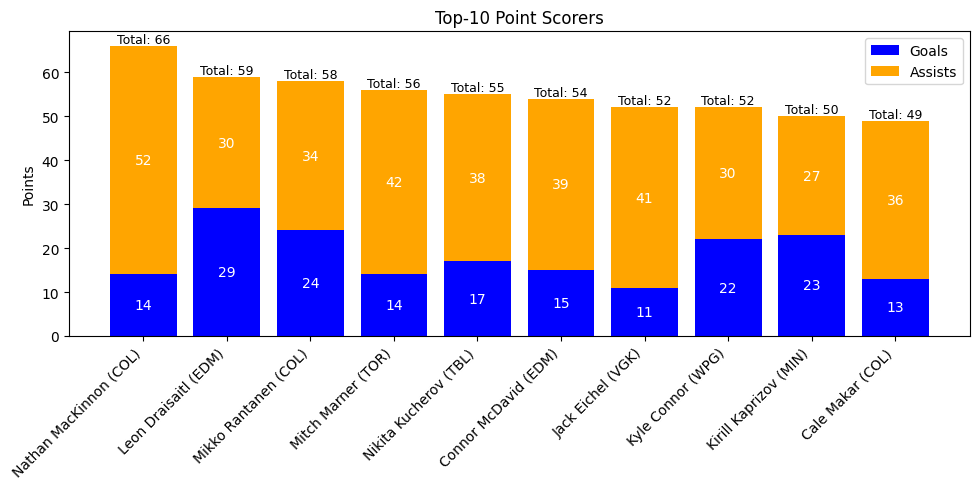

In [317]:
fig, ax = plt.subplots(figsize=(10,5))
bars_goals = ax.bar(players, goals, label='Goals', color='blue')
bars_assists = ax.bar(players, assists, label='Assists', bottom=goals, color='orange')

for bar_goal, bar_assist, goal, assist in zip(bars_goals, bars_assists, goals, assists):
    # Label for Goals
    ax.text(
        bar_goal.get_x() + bar_goal.get_width() / 2,  # Center x-coordinate
        bar_goal.get_height() / 2,                   # Midpoint of the bar
        str(goal),                                   # Goal value
        ha='center', va='center', color='white'
    )
    
    # Label for Assists
    ax.text(
        bar_assist.get_x() + bar_assist.get_width() / 2,  # Center x-coordinate
        bar_goal.get_height() + bar_assist.get_height() / 2,  # Midpoint of the top bar
        str(assist),                                     # Assist value
        ha='center', va='center', color='white'
    )

# Add total points label above the stacked bars
for i, total in enumerate(top10_point_scorers['points']):
    ax.text(
        i,                                               # x-coordinate (index of bar)
        goals.iloc[i] + assists.iloc[i],             # Slightly above the top bar
        f"Total: {total}",                               # Total points value
        ha='center', va='bottom', fontsize=9, color='black'
    )

ax.set_title('Top-10 Point Scorers')
ax.set_ylabel('Points')
ax.legend()

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Goalie Save Percentage against the League average 

In [318]:
df_goalies_performance.head()

,gameId,teamAbbrev,homeRoadFlag,gameDate,goals,assists,gamesStarted,decision,shotsAgainst,goalsAgainst,...,headshot,firstName,lastName,sweaterNumber,positionCode,shootsCatches,heightInCentimeters,weightInKilograms,birthDate,birthCountry
0,2024020597,WPG,R,2024-12-31,0,0,1,L,36,3,...,https://assets.nhle.com/mugs/nhl/20242025/WPG/...,Eric,Comrie,1,G,L,185,86,1995-07-06,CAN
1,2024020511,WPG,R,2024-12-18,0,0,1,L,31,3,...,https://assets.nhle.com/mugs/nhl/20242025/WPG/...,Eric,Comrie,1,G,L,185,86,1995-07-06,CAN
2,2024020439,WPG,H,2024-12-08,0,0,1,L,27,3,...,https://assets.nhle.com/mugs/nhl/20242025/WPG/...,Eric,Comrie,1,G,L,185,86,1995-07-06,CAN
3,2024020374,WPG,R,2024-11-29,0,0,1,L,30,4,...,https://assets.nhle.com/mugs/nhl/20242025/WPG/...,Eric,Comrie,1,G,L,185,86,1995-07-06,CAN
4,2024020329,WPG,R,2024-11-23,0,0,1,L,35,3,...,https://assets.nhle.com/mugs/nhl/20242025/WPG/...,Eric,Comrie,1,G,L,185,86,1995-07-06,CAN


In [319]:
top5_goalies_save_pct = df_goalies_performance.groupby(by=['id']).agg(
    shotsAgainst = ('shotsAgainst', 'sum'),
    goalsAgainst = ('goalsAgainst', 'sum'),
    gamesPlayed = ('gameId', 'count')
    ).reset_index()

In [320]:
top5_goalies_save_pct['savePct'] = 1 - top5_goalies_save_pct['goalsAgainst']/top5_goalies_save_pct['shotsAgainst']

In [321]:
min_games_played = (df_goalies_performance.groupby('teamAbbrev')['gameDate'].count().mean() * 0.35).round()

In [322]:
min_games_played

np.float64(14.0)

In [323]:
top5_goalies_save_pct.loc[top5_goalies_save_pct['gamesPlayed'] > min_games_played].sort_values(by=['savePct'], ascending=False).reset_index().drop(columns=['index']).head(5)

,id,shotsAgainst,goalsAgainst,gamesPlayed,savePct
0,8476932,480,35,17,0.927083
1,8476945,906,67,32,0.926049
2,8479406,793,59,27,0.925599
3,8475311,510,42,19,0.917647
4,8478406,809,67,28,0.917182


In [324]:
top5_goalies_save_pct = top5_goalies_save_pct.loc[top5_goalies_save_pct['gamesPlayed'] > min_games_played].sort_values(by=['savePct'], ascending=False).reset_index().drop(columns=['index']).head(5)

In [325]:
top5_goalies_save_pct_ids = top5_goalies_save_pct['id']

In [326]:
top5_goalies_save_pct_logs = df_goalies_performance[
    df_goalies_performance['id'].isin(top5_goalies_save_pct_ids)
    ][['id', 'gameDate','firstName', 'lastName', 'teamAbbrev', 'shotsAgainst', 'goalsAgainst']].sort_values(by=['id', 'gameDate'])

In [327]:
top5_goalies_save_pct_logs['id'].unique()

array([8475311, 8476932, 8476945, 8478406, 8479406])

In [328]:
top5_goalies_save_pct_logs['savePercent'] = 1 - top5_goalies_save_pct_logs['goalsAgainst'] / top5_goalies_save_pct_logs ['shotsAgainst']

In [329]:
top5_goalies_save_pct_logs.groupby('id')['savePercent'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)

373    0.969697
372    0.946387
371    0.899217
370    0.905182
369    0.901069
         ...   
261    0.890276
260    0.888983
259    0.885279
258    0.904236
257    0.942697
Name: savePercent, Length: 123, dtype: float64

In [330]:
top5_goalies_save_pct_logs['rollingSavePercent'] = top5_goalies_save_pct_logs.groupby('id')['savePercent'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)

In [331]:
top5_goalies_save_pct_logs['label'] = top5_goalies_save_pct_logs['firstName'] + ' ' + top5_goalies_save_pct_logs['lastName'] + ' (' + top5_goalies_save_pct_logs['teamAbbrev'] + ')'

In [332]:
top5_goalies_save_pct_logs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123 entries, 373 to 257
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  123 non-null    int64  
 1   gameDate            123 non-null    object 
 2   firstName           123 non-null    object 
 3   lastName            123 non-null    object 
 4   teamAbbrev          123 non-null    object 
 5   shotsAgainst        123 non-null    int64  
 6   goalsAgainst        123 non-null    int64  
 7   savePercent         123 non-null    float64
 8   rollingSavePercent  123 non-null    float64
 9   label               123 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 10.6+ KB


In [333]:
top5_goalies_save_pct_logs = top5_goalies_save_pct_logs.astype({'gameDate': 'datetime64[s]'})

In [334]:
top5_goalies_save_pct_logs

,id,gameDate,firstName,lastName,teamAbbrev,shotsAgainst,goalsAgainst,savePercent,rollingSavePercent,label
373,8475311,2024-10-10,Darcy,Kuemper,LAK,33,1,0.969697,0.969697,Darcy Kuemper (LAK)
372,8475311,2024-10-12,Darcy,Kuemper,LAK,26,2,0.923077,0.946387,Darcy Kuemper (LAK)
371,8475311,2024-10-14,Darcy,Kuemper,LAK,41,8,0.804878,0.899217,Darcy Kuemper (LAK)
370,8475311,2024-10-26,Darcy,Kuemper,LAK,26,2,0.923077,0.905182,Darcy Kuemper (LAK)
369,8475311,2024-10-30,Darcy,Kuemper,LAK,26,3,0.884615,0.901069,Darcy Kuemper (LAK)
...,...,...,...,...,...,...,...,...,...,...
261,8479406,2024-12-23,Filip,Gustavsson,MIN,31,3,0.903226,0.890276,Filip Gustavsson (MIN)
260,8479406,2024-12-27,Filip,Gustavsson,MIN,29,2,0.931034,0.888983,Filip Gustavsson (MIN)
259,8479406,2024-12-29,Filip,Gustavsson,MIN,36,2,0.944444,0.885279,Filip Gustavsson (MIN)
258,8479406,2024-12-31,Filip,Gustavsson,MIN,46,3,0.934783,0.904236,Filip Gustavsson (MIN)


In [335]:
all_dates = pd.date_range(start=top5_goalies_save_pct_logs['gameDate'].min(), end=top5_goalies_save_pct_logs['gameDate'].max())

In [336]:
aligned_data = []

for id, group in top5_goalies_save_pct_logs.groupby('id'):
    group = group.set_index('gameDate').reindex(all_dates)
    group['id'] = id
    group['rollingSavePercent'] = group['rollingSavePercent'].interpolate(limit_area='inside')
    aligned_data.append(group)

top5_goalies_save_pct_logs_aligned = pd.concat(aligned_data)

top5_goalies_save_pct_logs_aligned = top5_goalies_save_pct_logs_aligned.reset_index().rename(columns={'index':'gameDate'})

top5_goalies_save_pct_logs_aligned['label'] = (
    top5_goalies_save_pct_logs_aligned['label'].dropna()
)

In [337]:
top5_goalies_save_pct_logs_aligned.loc[top5_goalies_save_pct_logs_aligned['id'] == 8480843].head()

,gameDate,id,firstName,lastName,teamAbbrev,shotsAgainst,goalsAgainst,savePercent,rollingSavePercent,label


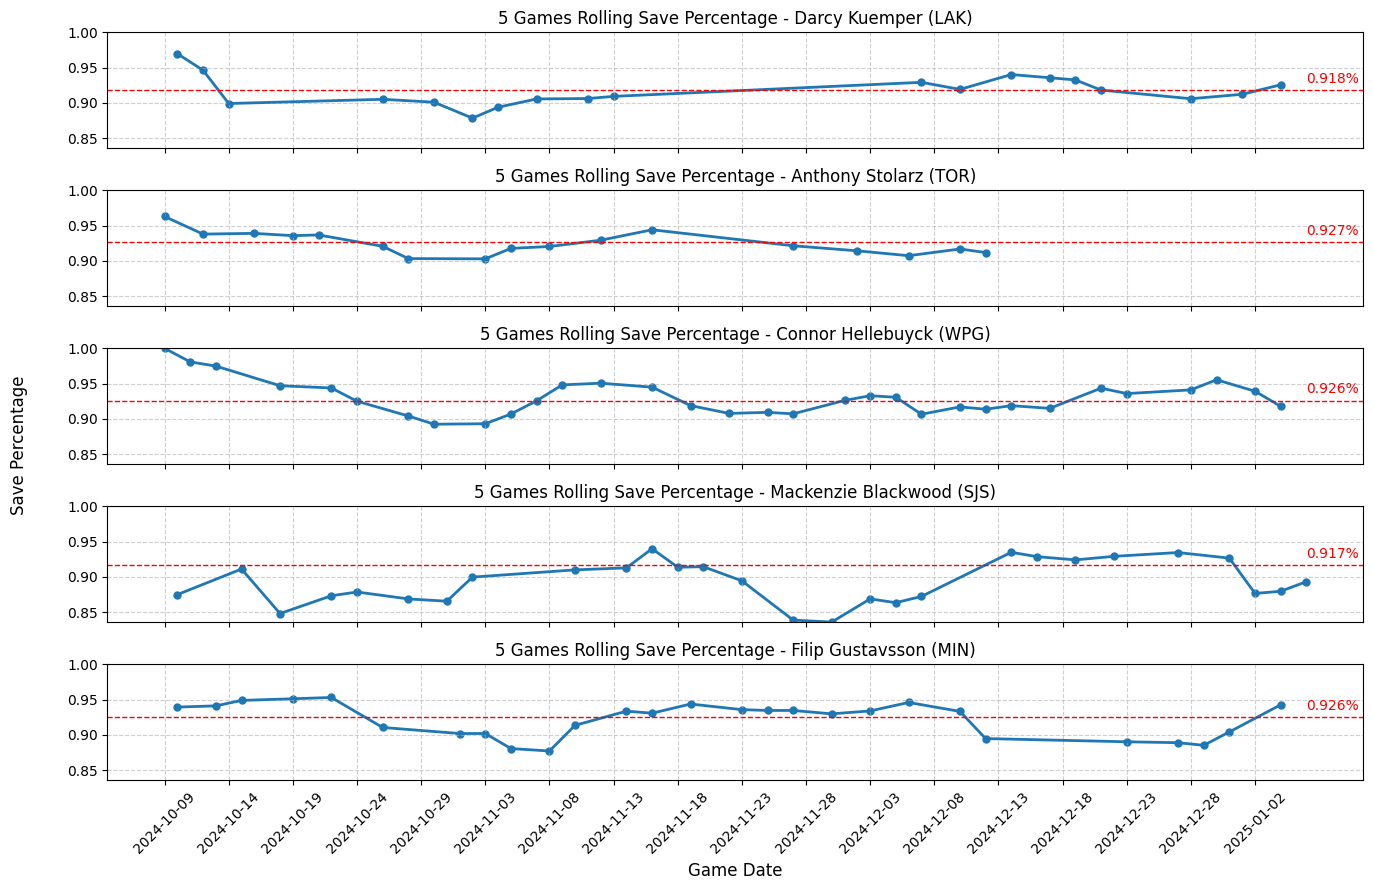

In [338]:
# Determine global Y-axis limits
y_min = top5_goalies_save_pct_logs_aligned['rollingSavePercent'].min()
y_max = top5_goalies_save_pct_logs_aligned['rollingSavePercent'].max()

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(14, 10), sharex=True)

# Iterate over subplots and goalie data
for ax, (id, group) in zip(axes, top5_goalies_save_pct_logs_aligned.groupby('id')):
    group_label = group['label'][group['label'].notnull()].unique()[0]
    avg_save_pct = 1- group['goalsAgainst'].sum() / group['shotsAgainst'].sum()

    # Line plot for rolling save percentage
    ax.plot(
        group['gameDate'], 
        group['rollingSavePercent'], 
        label=group_label,
        linewidth=2
    )
    
    # Scatter plot for save percentage points
    ax.scatter(
        group.loc[group['savePercent'].notna()]['gameDate'],
        group.loc[group['savePercent'].notna()]['rollingSavePercent'],
        marker='.',
        linewidths=3
    )

    ax.axhline(
        y=avg_save_pct,
        linewidth=1,
        linestyle='--',
        color='red',
        label=f'Avg. Save %'
    )

    ax.text(
        group['gameDate'].iloc[-1],  # Last game's date for placement
        avg_save_pct + 0.01,
        f"{avg_save_pct:.3f}%", 
        color='red', 
        fontsize=10, 
    )

    # Title, grid, and set uniform Y-axis limits
    ax.set_title(f"5 Games Rolling Save Percentage - {group_label}", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_ylim(y_min, y_max)  # Set consistent Y limits

# Global settings
axes[-1].set_xlabel('Game Date', fontsize=12)  # Add X-axis label only to the last subplot

# Global Y-axis label placed outside the chart area
fig.text(0.02, 0.5, 'Save Percentage', va='center', rotation='vertical', fontsize=12)

# Set uniform X ticks and format
xticks = top5_goalies_save_pct_logs_aligned['gameDate'].unique()  # Get unique X values
axes[-1].set_xticks(xticks[::5])  # Use every 5th tick for clarity
axes[-1].tick_params(axis='x', rotation=45)


# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Add padding for labels
plt.show()


## Load data in Google Cloud Storage

In [339]:
from google.cloud import storage
import datetime

In [340]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="creds/creds.json"

In [341]:
bucket_name = 'nhl-api-bucket'

In [342]:
client = storage.Client()

In [343]:
client.get_bucket(bucket_name)

<Bucket: nhl-api-bucket>

Uploading df_skaters_performance and df_goalies_performance data into a cloud bucket.

In [344]:
bucket = client.bucket('nhl-api-bucket')

In [345]:
ts = datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S")

In [346]:
file_name = f"skaters_performance_{ts}"
blob = bucket.blob(f'{file_name}.csv')

In [347]:
blob.upload_from_string(df_skaters_performance.to_csv(index=False), 'text/csv')

Load data from GCS into a BQ table

In [348]:
from google.cloud import bigquery

In [349]:
bq_client = bigquery.Client()

In [350]:
dataset_id = "stg_nhl_data"

try: 
    bq_client.get_dataset(dataset_id)
except Exception:
    bq_client.create_dataset(dataset_id)

In [351]:
table_id = f"silent-effect-287314.{dataset_id}.{file_name}"

In [ ]:
def infer_schema(df):
    schema = []
    for col, dtype in zip(df.columns, df.dtypes):
        if dtype == "int64":
            field_type = "INT64"
        elif dtype == "float64":
            field_type = "FLOAT"
        elif dtype == "object":
            field_type = "STRING"
        elif dtype.name.startswith("datetime"):
            field_type = "DATETIME"
        else:
            field_type = "STRING"
        schema.append(bigquery.SchemaField(col, field_type))
    return schema

In [358]:
schema = infer_schema(df_skaters_performance)

In [ ]:
job_config = bigquery.LoadJobConfig(
    schema=schema
    skip_leading_rows=1
)

In [353]:
uri = f"gs://{bucket_name}/{file_name}.csv"

In [354]:
load_job = bq_client.load_table_from_uri(
    uri, table_id, job_config=job_config
)

In [355]:
load_job.result()  # Waits for the job to complete.

LoadJob<project=silent-effect-287314, location=US, id=be664fa6-64b1-4c1c-8967-ad1a9c8f7d14>

In [356]:
destination_table = bq_client.get_table(table_id)
print("Loaded {} rows.".format(destination_table.num_rows))

Loaded 22274 rows.
